In [2]:
import jax.numpy as jnp
from jax import grad, jit
import MDAnalysis as mda
import matplotlib.pyplot as plt

### Protein backbone, C alpha

In [3]:
# Load trajectory and topology
xtc_file = "/Users/sss/Documents/EnergyGap_project/rc_example/md.xtc"
tpr_file = "/Users/sss/Documents/EnergyGap_project/ENG_cv_codes/md.tpr"


u = mda.Universe(tpr_file, xtc_file)
u.trajectory[50] #select frame index
ca_atoms = u.select_atoms("name CA") #protein backbone

positions = ca_atoms.positions 
positions.shape
print(len(positions))

20


### Construct the line segments using finite differences approximation

In [4]:
tangents = jnp.diff(positions, axis=0)
tangents_norm = jnp.linalg.norm(tangents, axis=1, keepdims=True)
segments = tangents / tangents_norm

segments.shape

(19, 3)

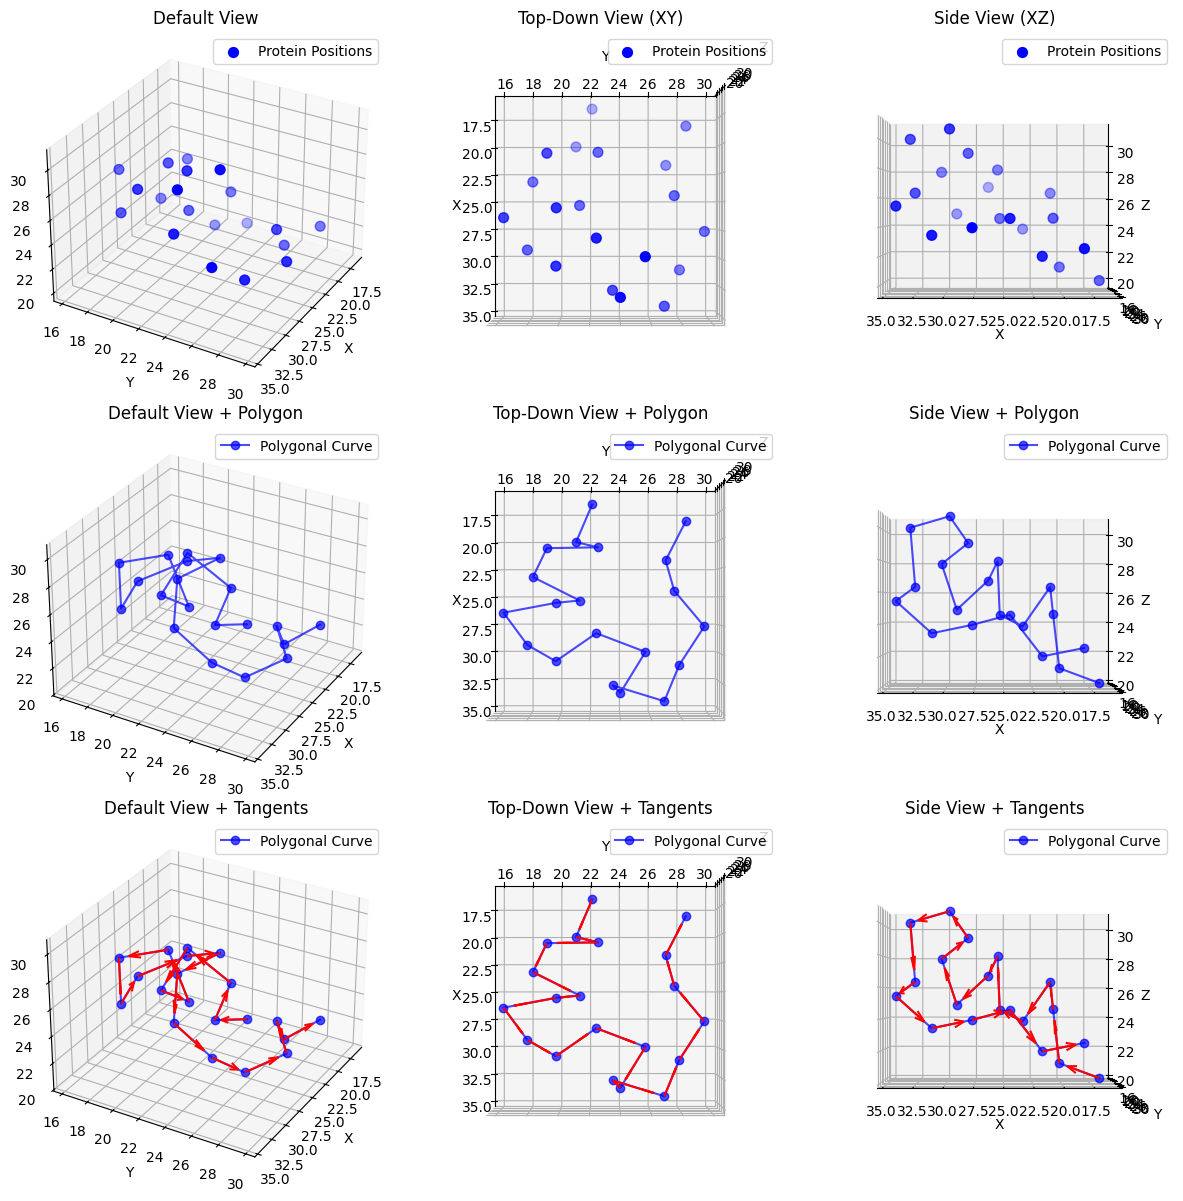

In [5]:
fig = plt.figure(figsize=(12, 12))  


view_angles = [(30, 30), (90, 0), (0, 90)]  # (elevation, azimuth)
titles_positions = ["Default View", "Top-Down View (XY)", "Side View (XZ)"]
titles_curve = ["Default View + Polygon", "Top-Down View + Polygon", "Side View + Polygon"]
titles_tangents = ["Default View + Tangents", "Top-Down View + Tangents", "Side View + Tangents"]

# Only Positions 
for i, (elev, azim) in enumerate(view_angles):
    ax = fig.add_subplot(3, 3, i + 1, projection='3d')

    ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], 
               color='blue', s=50, label="Protein Positions")

    # Set viewing angle
    ax.view_init(elev=elev, azim=azim)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(titles_positions[i])
    ax.legend()

# Polygonal Curve (Line Plot)
for i, (elev, azim) in enumerate(view_angles):
    ax = fig.add_subplot(3, 3, i + 4, projection='3d')

    # Plot Polygonal Curve (Backbone connectivity)
    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], 
            'bo-', alpha=0.7, label="Polygonal Curve")

    ax.view_init(elev=elev, azim=azim)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(titles_curve[i])
    ax.legend()

# Polygonal Curve + Tangents (Quiver plot)
for i, (elev, azim) in enumerate(view_angles):
    ax = fig.add_subplot(3, 3, i + 7, projection='3d')

    
    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], 
            'bo-', alpha=0.7, label="Polygonal Curve")

    # Plot Tangent Vectors
    for j in range(len(tangents)):
        ax.quiver(positions[j, 0], positions[j, 1], positions[j, 2],  
                  tangents[j, 0], tangents[j, 1], tangents[j, 2], 
                  color='red', length=0.8, arrow_length_ratio=0.3, normalize=False)


    ax.view_init(elev=elev, azim=azim)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(titles_tangents[i])
    ax.legend()

plt.tight_layout()
plt.show()


# Writhe Function  

The writhe function is a mathematical measure of the self-entanglement of a curve in 3D space. It originates from the Gauss linking integral, which computes the topological linking between two curves.  
In the case of a single curve, the writhe describes how much the curve twists around itself.


$$
Wr(C) = \frac{1}{4\pi} \int_C \int_C \frac{(\dot{\gamma}(s) \times \dot{\gamma}(t)) \cdot (\gamma(s) - \gamma(t))}{|\gamma(s) - \gamma(t)|^3} \, ds \, dt
$$

where:  
$\gamma(ti)$ is the parameterized curve.  
$ \dot{\gamma}(ti) $ is the tangent vector.  
$\ (\dot{\gamma}(ti) \times \dot{\gamma}(tj)) $ is the **cross product** of tangents.  
$\ (\gamma(ti) - \gamma(tj)|^3 )$ normalizes the integral.



## **Kernel Function: Scalar Triple Product**
The scalar triple product is the core mathematical operation, which encodes the geometric twisting between two segments of the curve:

$$
K(i, j) = \frac{t_i \cdot (t_j \times (r_i - r_j))}{|r_i - r_j|^3}
$$

where:  

$t_i$ and $t_j$ are tangent vectors.  
$r_i$, $r_j$ are points on the curve. 





## **2-Simplex Restriction**
Instead of computing over all possible point pairs, the 2-simplex restriction was nused to consider segments rather than individual points.

The indices are restricted to ensure $i > j$, preventing redundant calculations.


Mathematically, this is done by setting a triangular matrix:

$$
i, j = \text{triu\_indices}(N - 1, k=1)
$$


## **Final Computation of the Writhe**
The final **writhe sum** is computed as:

$$
Wr = \frac{1}{2\pi} \sum_{i > j} \frac{t_i \cdot (t_j \times (r_i - r_j))}{|r_i - r_j|^3}
$$

where the **sum runs over all distinct segment pairs**.


In [6]:
def compute_writhe_simplex(positions):
    """
    Compute the writhe of a protein backbone using the 2-simplex formulation.

    Parameters:
        positions: jnp.array of shape (N, 3), where N is the number of residues.
        
    Returns:
        Writhe value (scalar)
    """
    N = positions.shape[0]

    # Compute tangent vectors (finite difference approximation)
    tangents = jnp.diff(positions, axis=0)
    tangents /= jnp.linalg.norm(tangents, axis=1, keepdims=True)  # Normalize

    # Generate all index pairs (i, j) with i > j (strictly upper triangular part)
    i_idx, j_idx = jnp.triu_indices(N - 1, k=1)  # k=1 ensures i > j

    # Extract relevant points and tangents
    r_i, r_j = positions[i_idx], positions[j_idx]
    t_i, t_j = tangents[i_idx], tangents[j_idx]

    # Compute pairwise displacement vectors
    diff = r_i - r_j  # Shape: (M, 3)

    # Compute cross product t_j x (r_i - r_j)
    cross_prod = jnp.cross(t_j, diff)  # Shape: (M, 3)

    # Compute scalar triple product: t_i ⋅ (t_j × (r_i - r_j))
    scalar_triple_product = jnp.einsum("ij,ij->i", t_i, cross_prod)

# t_i.shape = (N-1, N-1, 3)  # (i, j, k)
# cross_prod.shape = (N-1, N-1, 3)  # (i, j, k)

# First axis (i): Iterates over the first segment.
# Second axis (j): Iterates over the second segment.
# Third axis (k) (the "last axis"): Represents the three spatial coordinates (x, y, z).
# So for each pair of segments (i, j), we have a 3D vector 
# (x,y,z).


    distance_cubed = jnp.linalg.norm(diff, axis=1) ** 3
    distance_cubed = jnp.where(distance_cubed == 0, jnp.inf, distance_cubed)  # Avoid division by zero

    # Compute writhe sum witht he restriction.
    writhe_sum = jnp.sum(scalar_triple_product / distance_cubed)

    # Finall, with the normalization factor
    writhe = (1 / (2 * jnp.pi)) * writhe_sum  # Factor adjusted for simplex

    return writhe



writhe_grade = jit(grad(compute_writhe_simplex))(positions)
print(f"writhe is: {compute_writhe_simplex(positions)}, grad is: {writhe_grade}")
%timeit writhe_grade

writhe is: 0.05426153913140297, grad is: [[ 1.2485484e-03 -1.8076668e-04 -8.5330103e-05]
 [ 2.1215125e-03  1.0159978e-03  3.0199196e-03]
 [ 1.0973817e-03 -4.2716446e-03 -3.8521970e-03]
 [-6.3774700e-04  1.0014926e-03  5.8002467e-04]
 [ 1.0663252e-03  2.8617589e-03  1.0862364e-05]
 [ 7.8304450e-04 -4.0782634e-03  3.0026769e-03]
 [-3.9907047e-03  1.0601659e-03 -2.4796126e-03]
 [-2.3899367e-03 -9.9323434e-04  1.4852982e-03]
 [-5.7786424e-04  1.9773101e-03  1.7562443e-03]
 [-1.0396809e-03  4.7159879e-03 -4.0223980e-03]
 [ 4.9246345e-03  3.9318083e-03 -5.7654688e-03]
 [-1.5338077e-03 -3.5728146e-03  3.0863737e-03]
 [ 9.3498710e-04 -3.2829945e-03  3.3263962e-03]
 [ 1.4921688e-03  2.6180758e-03  1.3705152e-03]
 [-2.0069373e-03 -6.0714828e-04 -1.2289749e-03]
 [-8.3730789e-04 -1.8641031e-03 -6.9655129e-04]
 [ 9.1257098e-04 -1.3209056e-03 -8.0916286e-04]
 [ 6.5289286e-04  1.0787053e-03 -1.4633010e-03]
 [-2.4265118e-03  2.5524548e-04  6.3989277e-04]
 [ 2.0643126e-04 -3.4467346e-04  2.1247929e-03]

# Higher-order topological invariant   
### These measures are inspired by the formulas for the **Vassiliev knot**
### This function extends the writhe computation above to capturing triplet-based entanglements rather than just pairwise crossings.

In [7]:
from itertools import combinations

def compute_higher_order_I(positions):
    N = len(positions)

    tangents = jnp.diff(positions, axis=0)
    tangents /= jnp.linalg.norm(tangents, axis=1, keepdims=True)


    # Generate distinct triplets for (i1, i2, i3) from the first half of the protein
    triplets_1 = jnp.array(list(combinations(range(N // 2), 3)))  # First half

    # Generate distinct triplets for (i4, i5, i6) from the second half of the protein
    triplets_2 = jnp.array(list(combinations(range(N // 2, N + 1), 3)))  # Second half


    min_triplets = min(triplets_1.shape[0], triplets_2.shape[0])

    # Trim to ensure they have the same shape
    triplets_1 = triplets_1[:min_triplets]
    triplets_2 = triplets_2[:min_triplets]

    # Extract indices
    i1, i2, i3 = triplets_1[:, 0], triplets_1[:, 1], triplets_1[:, 2]
    i4, i5, i6 = triplets_2[:, 0], triplets_2[:, 1], triplets_2[:, 2]



    # Compute displacement vectors
    diff_15 = positions[i1] - positions[i5]
    diff_24 = positions[i2] - positions[i4]
    diff_36 = positions[i3] - positions[i6]

    # Compute cross products
    cross_15 = jnp.cross(tangents[i1], diff_15)
    cross_24 = jnp.cross(tangents[i2], diff_24)
    cross_36 = jnp.cross(tangents[i3], diff_36)

    # Compute norms for normalization
    norm_15 = jnp.linalg.norm(diff_15, axis=1) ** 3
    norm_24 = jnp.linalg.norm(diff_24, axis=1) ** 3
    norm_36 = jnp.linalg.norm(diff_36, axis=1) ** 3

    # Compute kernel functions
    kernel_15 = jnp.einsum("ij,ij->i", cross_15, diff_15) / norm_15
    kernel_24 = jnp.einsum("ij,ij->i", cross_24, diff_24) / norm_24
    kernel_36 = jnp.einsum("ij,ij->i", cross_36, diff_36) / norm_36

    # Compute the higher-order invariant sum
    I_value = jnp.sum(kernel_15 * kernel_24 * kernel_36) / (3 * jnp.pi)

    return I_value

# JIT compilation
compute_higher_order_I_jit = jit(compute_higher_order_I)



#I_value = compute_higher_order_I(positions)
I_value_jitted = compute_higher_order_I_jit(positions)


grad_I = jit(grad(compute_higher_order_I))(positions)

print(f"Computed Higher-Order I: {I_value_jitted:.10f},")
print(f"Computed Higher-Order I grad: {grad_I}")

Computed Higher-Order I: -0.0000000000,
Computed Higher-Order I grad: [[-2.7761991e-29  1.9633580e-29  2.3375512e-28]
 [ 1.1583089e-28  3.2542713e-28 -8.0646246e-28]
 [ 2.8198154e-28  2.1203011e-28  4.8566171e-28]
 [ 4.6919415e-29 -2.7070905e-28 -1.8487646e-28]
 [-1.1067237e-28  2.0712650e-28 -2.3332800e-28]
 [-1.1838475e-27 -7.6979290e-28  3.3229552e-28]
 [ 8.3456746e-28 -3.6629334e-28 -1.3139262e-28]
 [-6.9192399e-28 -2.0393535e-27  5.9961970e-28]
 [-3.9144182e-28 -8.9411365e-28  2.7433635e-28]
 [-8.8844458e-28 -6.2097172e-28 -7.7368843e-29]
 [ 7.9048080e-28 -1.9812164e-28  2.4928924e-28]
 [-1.1359597e-28  2.9345626e-28 -5.9322340e-28]
 [ 1.8301573e-28  7.2575203e-29 -1.2621775e-29]
 [ 4.2282945e-28  1.8853776e-27 -9.1507865e-29]
 [ 1.0791617e-27  5.7192416e-28  2.3981372e-28]
 [-1.0728508e-28 -3.1160006e-29  7.5730647e-29]
 [-5.0487098e-28 -8.8352421e-29 -4.5438388e-28]
 [ 3.5340969e-28  4.4807299e-28 -2.2088105e-29]
 [ 2.8398993e-28  1.2621774e-28 -2.5243549e-29]
 [-2.7136815e-28  